# **Part 1:** Data Preparation (Ching-min & Dandan)##

Chosen Superclass: Small mammals and Medium-sized mammals.

In [0]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [75.1 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 k

In [0]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
# Import the necessary packages
%%time
import findspark
findspark.init(os.environ["SPARK_HOME"])# SPARK_HOME
from pyspark.sql.types import Row
from pyspark.ml.linalg import Vectors, DenseVector
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
import numpy as np
import json


CPU times: user 228 ms, sys: 26 ms, total: 254 ms
Wall time: 258 ms


In [0]:
# Increase the memory limit/maximum memory configuration - https://datascience.stackexchange.com/questions/8549/how-do-i-set-get-heap-size-for-spark-via-python-notebook
#spark = SparkSession.builder.master("local[*]").getOrCreate()
%%time
Memory_limit = "12g"
spark = SparkSession.builder.appName("Foo").config("spark.executor.memory", Memory_limit).config("spark.driver.memory", Memory_limit).getOrCreate()
#spark = SparkSession.builder.appName("App").config("spark.executor.memory", Memory_limit).config("spark.driver.memory", Memory_limit)\
        #.config("spark.driver.maxResultSize", '10G').config('spark.executor.cores', '2').config("spark.driver.cores","4").config("spark.num.executors","4").getOrCreate()

"""https://www.edureka.co/community/5268/how-to-change-the-spark-session-configuration-in-pyspark
config = pyspark.SparkConf().setAll([('spark.executor.memory', '12g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','12g')])
sc.stop()
sc = pyspark.SparkContext(conf=config)"""


CPU times: user 34.6 ms, sys: 13.8 ms, total: 48.3 ms
Wall time: 5.78 s


## **Download data**

In [0]:
#2. Get the file
# Make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
%%time
downloaded1 = drive.CreateFile({'id':'1YoyOoPty-a3i8oMStdheWrDTCKrcONG3'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('train')
downloaded2 = drive.CreateFile({'id':'1Qe_Z5HGgdF2_c8XoypiCIGutK6wAvb8e'}) # replace the id with id of file you want to access
downloaded2.GetContentFile('test')
downloaded3 = drive.CreateFile({'id':'1eqHqAAOx0OuMhnpgTkBlvUPx9eGH0snZ'}) # replace the id with id of file you want to access
downloaded3.GetContentFile('meta')

CPU times: user 395 ms, sys: 657 ms, total: 1.05 s
Wall time: 5.38 s


In [0]:
# Unpickle the file
%%time
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='bytes')
    return dic

# Fetch the Train data
datatrain = unpickle('train')

# Fetch the test data
datatest = unpickle('test')

# Fetch the metadata
datameta = unpickle("meta")

# Convert the data type from byte to utf-8
fine_labels = [x.decode('utf-8')for x in datameta.get(b'fine_label_names')]
print(fine_labels)
coarse_labels = [x.decode('utf-8')for x in datameta.get(b'coarse_label_names')]
print(coarse_labels)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [0]:
# Generate the train data RDD
%%time
cifar_train_RDD = spark.sparkContext.parallelize(list(zip( \
    [name.decode('utf-8') for name in datatrain.get(b'filenames')],\
    datatrain.get(b'fine_labels'), datatrain.get(b'coarse_labels'), \
    datatrain.get(b'data'))))
print (cifar_train_RDD.count())
cifar_train_RDD.map(lambda x: x[3]).take(1)

50000
CPU times: user 595 ms, sys: 343 ms, total: 938 ms
Wall time: 4.67 s


In [0]:
# Generate the test data RDD
%%time
cifar_test_RDD = spark.sparkContext.parallelize(list(zip( \
    [name.decode('utf-8') for name in datatest.get(b'filenames')],\
    datatest.get(b'fine_labels'), datatest.get(b'coarse_labels'), \
    datatest.get(b'data'))))
print (cifar_test_RDD.count())

10000
CPU times: user 122 ms, sys: 50.3 ms, total: 172 ms
Wall time: 417 ms


## **Combine the training RDD and test RDD into one RDD**

In [0]:
# Combine the train RDD and test RDD into one RDD, may take a long while to run
%%time
combine_rdd = cifar_train_RDD.union(cifar_test_RDD)
print (combine_rdd.count())

60000
CPU times: user 6.87 ms, sys: 3.17 ms, total: 10 ms
Wall time: 1.7 s


Seed is used to save the state of the random function in subsequent executions.

In [0]:
# Take a sample from the data
%%time
print (combine_rdd.takeSample(withReplacement=False, num=5, seed=123))

[('power_mower_s_000260.png', 41, 19, array([255, 242, 202, ..., 255, 252, 252], dtype=uint8)), ('bicycle_s_002728.png', 8, 18, array([0, 0, 0, ..., 4, 4, 6], dtype=uint8)), ('sunflower_s_000513.png', 82, 2, array([36, 43, 47, ..., 84, 90, 70], dtype=uint8)), ('poppy_s_001505.png', 62, 2, array([4, 4, 4, ..., 7, 7, 8], dtype=uint8)), ('rosebush_s_001692.png', 70, 2, array([23, 24, 26, ..., 66, 68, 68], dtype=uint8))]
CPU times: user 17.2 ms, sys: 2.43 ms, total: 19.6 ms
Wall time: 3.07 s


Here, we convert the RDD into Dataframe and normalize the image data by dividing it with the largest pixel value, which is 255.

In [0]:
# Convert the combined RDD into spark dataframe and normalize
%%time
combine_df = spark.createDataFrame(combine_rdd.map(lambda x: Row(filenames=x[0], fine_labels=int(x[1]), coarse_labels=int(x[2]), data=DenseVector(x[3])/255.0)) )
print (combine_df.count())

60000
CPU times: user 30.8 ms, sys: 5.91 ms, total: 36.7 ms
Wall time: 1min 49s


In [0]:
# Print the first 10 rows
%%time
combine_df.show()

+-------------+--------------------+--------------------+-----------+
|coarse_labels|                data|           filenames|fine_labels|
+-------------+--------------------+--------------------+-----------+
|           11|[1.0,1.0,1.0,1.0,...|bos_taurus_s_0005...|         19|
|           15|[1.0,0.9921568627...|stegosaurus_s_000...|         29|
|            4|[0.98039215686274...|mcintosh_s_000643...|          0|
|           14|[0.48627450980392...|altar_boy_s_00143...|         11|
|            1|[0.16862745098039...|cichlid_s_000031.png|          1|
|            5|[0.74509803921568...|  phone_s_002161.png|         86|
|           18|[0.19607843137254...|car_train_s_00004...|         90|
|            3|[0.69803921568627...| beaker_s_000604.png|         28|
|           10|[0.47843137254901...|    fog_s_000397.png|         23|
|           11|[1.0,1.0,1.0,1.0,...|rogue_elephant_s_...|         31|
|            5|[0.32549019607843...|computer_keyboard...|         39|
|           17|[0.99

## **Filter out the assigned superclasses**

In [0]:
# Get the index of ten classes of animals
%%time
#medium_sized_mammals_index = [ fine_labels.index(x) for x in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'] ]
#small_mammals_index = [ fine_labels.index(x) for x in ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'] ]

medium_sized_mammals_index = [ coarse_labels.index(x) for x in ['medium_mammals'] ]
small_mammals_index = [ coarse_labels.index(x) for x in ['small_mammals'] ]

target_index = medium_sized_mammals_index + small_mammals_index
print (medium_sized_mammals_index, small_mammals_index)
print(target_index)

[12] [16]
[12, 16]
CPU times: user 2.03 ms, sys: 1e+03 ns, total: 2.03 ms
Wall time: 5.54 ms


In [0]:
# Verify the label number
%%time
for ind in target_index:
  print ("Index", ind, "is for coarse label:", coarse_labels[ind])

Index 12 is for coarse label: medium_mammals
Index 16 is for coarse label: small_mammals
CPU times: user 2.01 ms, sys: 0 ns, total: 2.01 ms
Wall time: 3.58 ms


In [0]:
# Filter out the assigned ten fine classes, reorder columns and check the count
%%time
from pyspark.sql.functions import col

target_df = combine_df.filter(col('coarse_labels').isin(target_index))                 # Can do combine_df.filter((combine_df['coarse_labels']==12) | (combine_df['coarse_labels']==16))
target_df = target_df.select("data","coarse_labels","fine_labels","filenames")

print ("Count:", target_df.count())

Count: 6000
CPU times: user 15.3 ms, sys: 9.46 ms, total: 24.8 ms
Wall time: 1min 44s


In [0]:
# Import packages
%%time
from pyspark.sql.functions import udf, rand
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.mllib.linalg import VectorUDT

CPU times: user 9.05 ms, sys: 2.62 ms, total: 11.7 ms
Wall time: 12.1 ms


In [0]:
# Add two columns fine label as fine and coarse label as coarse
%%time
target_name_df = target_df.withColumn("coarse", udf(lambda coarse_label: coarse_labels[coarse_label], StringType())(target_df['coarse_labels'])) \
    .withColumn("fine", udf(lambda fine_label: fine_labels[fine_label], StringType())(target_df['fine_labels']))

CPU times: user 12.3 ms, sys: 43 µs, total: 12.4 ms
Wall time: 64.3 ms


# **Visualize and validate the data**

In [0]:
# Generate sample data randomly
%%time
fractions = dict()
for fine in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']:
  fractions[fine] = 0.02                              

sample_df = target_name_df.sampleBy('fine', fractions)
print(sample_df.count())

118
CPU times: user 18.8 ms, sys: 5.08 ms, total: 23.9 ms
Wall time: 1min 45s


In [0]:
# Generate the samples list
%%time
samples = sample_df.select('coarse', 'fine', 'data').orderBy('coarse', 'fine').rdd.collect()

CPU times: user 90 ms, sys: 10.8 ms, total: 101 ms
Wall time: 3min 31s


CPU times: user 654 ms, sys: 15.8 ms, total: 669 ms
Wall time: 684 ms


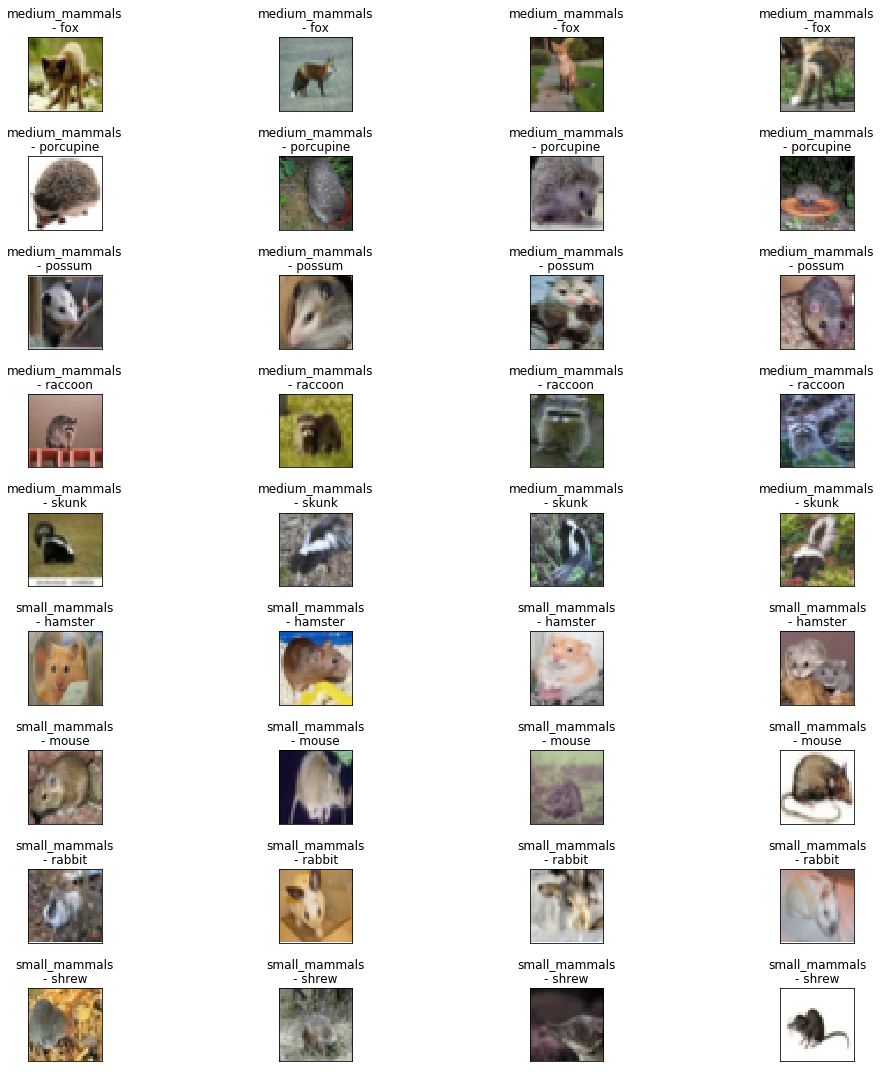

In [0]:
# Visualize the data
%%time
import matplotlib.pyplot as plt

# initialize the dict, the key is the ten fine class, the count is 0
counts = dict.fromkeys(['fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'], 0) 

fig = plt.figure(figsize=(15, 15))
index = 1
for sample in samples:
  counts[sample.fine] += 1
  if counts[sample.fine] > 4:
    continue
  
  img = sample.data.reshape(3,32,32).transpose([1, 2, 0])
  fig.add_subplot(9, 4, index, xticks=[], yticks=[])
  plt.imshow(img)
  plt.title("{}\n- {}".format(sample.coarse, sample.fine))
  index += 1
  if index > 36:
    break

fig.set_tight_layout(True)

# **Prediction on one testing subclass images from each of the two superclasses**

* Fine label aka subclass refers to an organism, such as Rabbit, fox, mouse etc.
* Course label aka superclass refers to their categorization, such as small and medium mammals.
* Each pair has one subclass each from small & medium mammals.

4 pairs comprising of 4 subclasses each from small and large mammals are set as training set, and the missing excluded pair (1 subclass each from small and large mammals) is set as testing set. As there are 5 subclasses each in small and large mammals, we will generate a list of 25 pairs with different combinations, each with 4 pairs as train set and 1 pair as test set.

##**Part 1:** Data Preparation (Ching-min & Dandan)

In [0]:
# Create a new datafrane with new columns
%%time
target_name_df2 = target_df.withColumn("coarse", udf(lambda coarse_label: coarse_labels[coarse_label],\
                                                    StringType())(target_df['coarse_labels'])) \
                          .withColumn("fine", udf(lambda fine_label: fine_labels[fine_label], \
                                                  StringType())(target_df['fine_labels']))

CPU times: user 11.8 ms, sys: 4.81 ms, total: 16.6 ms
Wall time: 87.2 ms


In [0]:
# Change the coarse label of training set into a binary label, and check the distinct binary labels
%%time
stringindexer = StringIndexer(inputCol='coarse_labels', outputCol='binary_index')
target_name_df2 = stringindexer.fit(target_name_df2).transform(target_name_df2)
target_name_df2.select('binary_index').distinct().collect()

CPU times: user 81 ms, sys: 15.4 ms, total: 96.4 ms
Wall time: 3min 32s


In [0]:
# Rename data as features and re-order columns 
%%time
target_name_df2 = target_name_df2.withColumnRenamed("data","features").select("features","binary_index", "coarse_labels","coarse","fine_labels","fine")

CPU times: user 6.77 ms, sys: 0 ns, total: 6.77 ms
Wall time: 63.2 ms


In [0]:
# Verify the data type
%%time
target_name_df2.dtypes

CPU times: user 2.29 ms, sys: 0 ns, total: 2.29 ms
Wall time: 16 ms


[('features', 'vector'),
 ('binary_index', 'double'),
 ('coarse_labels', 'bigint'),
 ('coarse', 'string'),
 ('fine_labels', 'bigint'),
 ('fine', 'string')]

In [0]:
# Check for null values in each column
%%time
for c in target_name_df2.columns: 
  print ("Column",c, "- no.of null values:", target_name_df2.where(col(c).isNull()).count()) 

Column features - no.of null values: 0
Column binary_index - no.of null values: 0
Column coarse_labels - no.of null values: 0
Column coarse - no.of null values: 0
Column fine_labels - no.of null values: 0
Column fine - no.of null values: 0
CPU times: user 80.6 ms, sys: 19.9 ms, total: 100 ms
Wall time: 8min 37s


In [0]:
# Check the distinct labels
%%time
print("Distinct labels in the training set -", target_name_df2.select('coarse_labels','binary_index','coarse','fine_labels','fine').distinct().collect())

Distinct labels in the training set - [Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals', fine_labels=74, fine='shrew'), Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals', fine_labels=80, fine='squirrel'), Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals', fine_labels=50, fine='mouse'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals', fine_labels=63, fine='porcupine'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals', fine_labels=66, fine='raccoon'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals', fine_labels=64, fine='possum'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals', fine_labels=34, fine='fox'), Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals', fine_labels=36, fine='hamster'), Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals', fine_labels=65, fine='rabbit'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals', fine_labels=75, fine='skun

We are skipping the check for null values as it was performed earlier. It is also very time-consuming.

In [0]:
# Store different missing pair of rdd
# Each list of rdd will have 25 different sets
%%time
train_list=[]
test_list=[]
test_label_list=spark.sparkContext.parallelize(())

CPU times: user 1.76 ms, sys: 0 ns, total: 1.76 ms
Wall time: 11.6 ms


In [0]:
# Fetch the fine labels of small and medium mammals
%%time
medium_sized_mammals_ind = [fine_labels.index(x) for x in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'] ]
small_mammals_ind = [fine_labels.index(x) for x in ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'] ]

CPU times: user 24 µs, sys: 8 µs, total: 32 µs
Wall time: 38.1 µs


In [0]:
# Create a loop to generate 25 pairs of train set with 4 pairs each of small and large mammals, and remaining 2 pairs as test set.
%%time
for a in medium_sized_mammals_ind:
    for b in small_mammals_ind :
        # test
        test_filter=target_name_df2.filter((target_name_df2.fine_labels==a) | (target_name_df2.fine_labels==b)) # extract the rows of missimg pair
        
        
        # train
        train_filter=target_name_df2.filter((target_name_df2.fine_labels!=a) & (target_name_df2.fine_labels!=b)) # extract the rows of else
        
        
        # add to list
        train_list.append(train_filter)
        test_list.append(test_filter)
        
        # test list
        temp=spark.sparkContext.parallelize([(fine_labels[a],fine_labels[b])])
        test_label_list=test_label_list.union(temp)

CPU times: user 105 ms, sys: 27.5 ms, total: 133 ms
Wall time: 1.24 s


In [0]:
"""# Let us view the values stored
%%time
for i in range(0,25):
  print("Trial",i, "->\t Testing set:")
  print(test_list[i].groupby('fine','coarse').count().show())
  print ("\t\t Training set:")
  print(train_list[i].groupby('fine','coarse').count().show(),"\n")

  # Can do orderBy but avoiding the same as it already takes 1.5 hours."""

'# Let us view the values stored\n%%time\nfor i in range(0,25):\n  print("Trial",i, "->\t Testing set:")\n  print(test_list[i].groupby(\'fine\',\'coarse\').count().show())\n  print ("\t\t Training set:")\n  print(train_list[i].groupby(\'fine\',\'coarse\').count().show(),"\n")\n\n  # Can do orderBy but avoiding the same as it already takes 1.5 hours.'

## Study the training data

In [0]:
# Check the length of training list, which gives the number of training sets
%%time
len(train_list)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


25

In [0]:
# Check the type of file
%%time
type(train_list[0])

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 10.7 µs


pyspark.sql.dataframe.DataFrame

In [0]:
# First 5 rows of train_list[0]
%%time
train_list[0].show(5)

+--------------------+------------+-------------+--------------+-----------+--------+
|            features|binary_index|coarse_labels|        coarse|fine_labels|    fine|
+--------------------+------------+-------------+--------------+-----------+--------+
|[0.27843137254901...|         0.0|           16| small_mammals|         80|squirrel|
|[0.61176470588235...|         0.0|           16| small_mammals|         74|   shrew|
|[0.96078431372549...|         1.0|           12|medium_mammals|         64|  possum|
|[1.0,1.0,1.0,1.0,...|         1.0|           12|medium_mammals|         64|  possum|
|[0.11764705882352...|         0.0|           16| small_mammals|         65|  rabbit|
+--------------------+------------+-------------+--------------+-----------+--------+
only showing top 5 rows

CPU times: user 8.27 ms, sys: 953 µs, total: 9.23 ms
Wall time: 42.7 s


In [0]:
# Verify the Schema
%%time
train_list[0].printSchema()

root
 |-- features: vector (nullable = true)
 |-- binary_index: double (nullable = false)
 |-- coarse_labels: long (nullable = true)
 |-- coarse: string (nullable = true)
 |-- fine_labels: long (nullable = true)
 |-- fine: string (nullable = true)

CPU times: user 525 µs, sys: 909 µs, total: 1.43 ms
Wall time: 2.83 ms


In [0]:
# Check the statistical features
%%time
train_list[0].describe().show()

+-------+------------------+------------------+--------------+-----------------+--------+
|summary|      binary_index|     coarse_labels|        coarse|      fine_labels|    fine|
+-------+------------------+------------------+--------------+-----------------+--------+
|  count|              4800|              4800|          4800|             4800|    4800|
|   mean|               0.5|              14.0|          null|           67.125|    null|
| stddev|0.5000520914727675|2.0002083658910697|          null|8.667469414257729|    null|
|    min|               0.0|                12|medium_mammals|               50|   mouse|
|    max|               1.0|                16| small_mammals|               80|squirrel|
+-------+------------------+------------------+--------------+-----------------+--------+

CPU times: user 15.7 ms, sys: 5.26 ms, total: 21 ms
Wall time: 1min 44s


In [0]:
# Check for distinct labels
%%time
train_list[0].select('fine_labels','fine','coarse').distinct().show()

+-----------+---------+--------------+
|fine_labels|     fine|        coarse|
+-----------+---------+--------------+
|         63|porcupine|medium_mammals|
|         50|    mouse| small_mammals|
|         66|  raccoon|medium_mammals|
|         75|    skunk|medium_mammals|
|         65|   rabbit| small_mammals|
|         64|   possum|medium_mammals|
|         74|    shrew| small_mammals|
|         80| squirrel| small_mammals|
+-----------+---------+--------------+

CPU times: user 36.2 ms, sys: 11.8 ms, total: 48 ms
Wall time: 1min 45s


## Study the testing data

In [0]:
# Check the length of the test file
len(test_list)

25

In [0]:
# Check the type of file
%%time
type(test_list[0])

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 10 µs


pyspark.sql.dataframe.DataFrame

In [0]:
# First 5 rows of test_list[0]
%%time
test_list[0].show(5)

+--------------------+------------+-------------+--------------+-----------+-------+
|            features|binary_index|coarse_labels|        coarse|fine_labels|   fine|
+--------------------+------------+-------------+--------------+-----------+-------+
|[0.23529411764705...|         0.0|           16| small_mammals|         36|hamster|
|[0.14117647058823...|         0.0|           16| small_mammals|         36|hamster|
|[0.48235294117647...|         1.0|           12|medium_mammals|         34|    fox|
|[0.71764705882352...|         0.0|           16| small_mammals|         36|hamster|
|[0.78431372549019...|         1.0|           12|medium_mammals|         34|    fox|
+--------------------+------------+-------------+--------------+-----------+-------+
only showing top 5 rows

CPU times: user 6.51 ms, sys: 1.96 ms, total: 8.47 ms
Wall time: 42.4 s


In [0]:
# Verify the Schema
%%time
test_list[0].printSchema()

root
 |-- features: vector (nullable = true)
 |-- binary_index: double (nullable = false)
 |-- coarse_labels: long (nullable = true)
 |-- coarse: string (nullable = true)
 |-- fine_labels: long (nullable = true)
 |-- fine: string (nullable = true)

CPU times: user 1.28 ms, sys: 812 µs, total: 2.09 ms
Wall time: 4.44 ms


In [0]:
# Check the statistical features
%%time
test_list[0].describe().show()

+-------+------------------+------------------+--------------+------------------+-------+
|summary|      binary_index|     coarse_labels|        coarse|       fine_labels|   fine|
+-------+------------------+------------------+--------------+------------------+-------+
|  count|              1200|              1200|          1200|              1200|   1200|
|   mean|               0.5|              14.0|          null|              35.0|   null|
| stddev|0.5002084636321551|2.0008338545286213|          null|1.0004169272643104|   null|
|    min|               0.0|                12|medium_mammals|                34|    fox|
|    max|               1.0|                16| small_mammals|                36|hamster|
+-------+------------------+------------------+--------------+------------------+-------+

CPU times: user 16.3 ms, sys: 4.13 ms, total: 20.4 ms
Wall time: 1min 44s


In [0]:
# Check for distinct labels
%%time
test_list[0].select('fine_labels','fine','coarse').distinct().show()

+-----------+-------+--------------+
|fine_labels|   fine|        coarse|
+-----------+-------+--------------+
|         36|hamster| small_mammals|
|         34|    fox|medium_mammals|
+-----------+-------+--------------+

CPU times: user 37 ms, sys: 6.66 ms, total: 43.6 ms
Wall time: 1min 44s


In [0]:
# Print the missing pair list
%%time
test_label_list.collect() 

CPU times: user 3.59 ms, sys: 870 µs, total: 4.46 ms
Wall time: 117 ms


[('fox', 'hamster'),
 ('fox', 'mouse'),
 ('fox', 'rabbit'),
 ('fox', 'shrew'),
 ('fox', 'squirrel'),
 ('porcupine', 'hamster'),
 ('porcupine', 'mouse'),
 ('porcupine', 'rabbit'),
 ('porcupine', 'shrew'),
 ('porcupine', 'squirrel'),
 ('possum', 'hamster'),
 ('possum', 'mouse'),
 ('possum', 'rabbit'),
 ('possum', 'shrew'),
 ('possum', 'squirrel'),
 ('raccoon', 'hamster'),
 ('raccoon', 'mouse'),
 ('raccoon', 'rabbit'),
 ('raccoon', 'shrew'),
 ('raccoon', 'squirrel'),
 ('skunk', 'hamster'),
 ('skunk', 'mouse'),
 ('skunk', 'rabbit'),
 ('skunk', 'shrew'),
 ('skunk', 'squirrel')]

## **Part2:** Model creation (Megha & Rajasree)



In [0]:
# Import the packages
%%time
import time
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

CPU times: user 129 µs, sys: 0 ns, total: 129 µs
Wall time: 139 µs


In [0]:
%%time
test_label_list.collect()[24]

CPU times: user 2.45 ms, sys: 1.85 ms, total: 4.3 ms
Wall time: 105 ms


('skunk', 'squirrel')

#### **Function** - for printing statistics - To double-check using ***Numpy as well as PySpark***

In [0]:
# Function for basic statistics
%%time
def basic_statistics(accuracy_list, test_label_list, train_cpuTime, train_wallTime,test_cpuTime, test_wallTime): 
  ind_max = np.argmax(accuracy_list)                               # Find the indices of best and worst performing pair
  ind_min = np.argmin(accuracy_list)                     
  ind_trainTimeMin = np.argmin(train_cpuTime)                      # Find the indices of best and worst train and test CPU time
  ind_trainTimeMax = np.argmax(train_cpuTime)
  ind_testTimeMin = np.argmin(test_cpuTime)
  ind_testTimeMax = np.argmax(test_cpuTime)

  print("Average accuracy: {:.2f}%".format(np.mean(accuracy_list)))                        # Print the average accuracy and time
  print("Average training CPU time: {:.2f} seconds".format(np.mean(train_cpuTime)))        # Average training time - CPU time
  print("Average training Wall time: {:.2f} minutes".format(np.mean(train_wallTime)))      # Average training time - Wall time
  print("Average testing CPU time: {:.2f} seconds".format(np.mean(test_cpuTime)))          # Average testing time - CPU time
  print("Average testing Wall time: {:.2f} minutes".format(np.mean(test_wallTime)))        # Average testing time - Wall time
  print("Minimum train CPU time - with test pair {}: {:.2f}%".format(test_label_list.collect()[ind_trainTimeMin],
                                                                                np.min(train_cpuTime)))              # for training
  print("Maximum train CPU time - with test pair {}: {:.2f}%".format(test_label_list.collect()[ind_trainTimeMax],     
                                                                                   np.max(train_cpuTime)),"\n")      # for training
  print("Minimum test CPU time - with test pair {}: {:.2f}%".format(test_label_list.collect()[ind_testTimeMin],     
                                                                                np.min(test_cpuTime)))               # for testing
  print("Maximum test CPU time - with test pair {}: {:.2f}%".format(test_label_list.collect()[ind_testTimeMax],        
                                                                                   np.max(test_cpuTime)),"\n")       # for testing
  print("Therefore, the test pair with the best accuracy of {:.2f}% is {}".format(np.max(accuracy_list),      
        test_label_list.collect()[ind_max]))      # Best pair
  print("and the test pair with the worst accuracy of {:.2f}% is {}".format(np.min(accuracy_list),
        test_label_list.collect()[ind_min]),"\n") # Worst pair

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11.4 µs


In [0]:
# Function for printing accuracy statistics
%%time
def accuracy_statistics(accuracy_list, test_label_list):
  ind_max = np.argmax(accuracy_list)                                        # Find the indices of best and worst performing pair
  ind_min = np.argmin(accuracy_list) 

  print("Statistics for the accuracy of the 25 trials ->\
         \n\nMean Accuracy: {:.2f}%".format(np.mean(accuracy_list)))                            # Mean
  print("Standard deviation: {:.2f}%".format(np.std(accuracy_list)))                            # Standard deviation
  print("25% (1st quantile) accuracy: {:.2f}%".format(np.percentile(accuracy_list, 25)))        # 25 perccentile
  print("50% (median or 2nd quantile) accuracy: {:.2f}%".format(np.percentile(accuracy_list, 50))) # Median or 50 percentile
  print("75% (3rd quantile) accuracy: {:.2f}%".format(np.percentile(accuracy_list, 75)))           # 75 percentile
  print("\nMinimum Accuracy - with worst-performing test pair {}: {:.2f}%".format(test_label_list.collect()[ind_min],\
                                                                                np.min(accuracy_list))) # Worst pair  
  print("Maximum accuracy - with the best-performing test pair {}: {:.2f}%".format(test_label_list.collect()[ind_max],\
                                                                                   np.max(accuracy_list)),"\n") # Best pair

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 10.5 µs


##**Model 1:** Logistic Regression

In [0]:
# Import the necesary packages
%%time
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

CPU times: user 6.88 ms, sys: 1.96 ms, total: 8.84 ms
Wall time: 17 ms


In [0]:
# Create new list to store the accuracy and time taken for each trial 
# to convert to RDD or dataframe 
%%time
lr_accuracy=[]
model_logreg=[]
lrTest_cpuTime=[]
lrTest_wallTime=[]
lrTrain_cpuTime=[]
lrTrain_wallTime=[]

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


### **Training phase - with time**

In [0]:
# Training with Logistic Regression
%%time
print("\033[1m \033[4m \033[94m {} \033[0m\n".format("Logistic Regression - Training phase")) # Print in underlined blue bold format

# Create a 'for' loop to generate 25 trials
for i in range(0,25):                                                       
  cpuTime_start, wallTime_start = time.clock(),time.time()                   # Record the start time in terms of CPU and wall time
  logreg = LogisticRegression(labelCol="binary_index", featuresCol="features",maxIter=10) 

  # Instantiate the model 
  model_lr=logreg.fit(train_list[i])                                         # Fit using the training set

  # Print the CPU time, wall time and accuracy
  cpuTime_stop, wallTime_stop = time.clock(),time.time()                     # Record the stop time in terms of CPU and wall time
  cpuTime,wallTime = (cpuTime_stop - cpuTime_start), (wallTime_stop - wallTime_start)  # Calculate CPU & wall time for each iteration
  print("Trial {} ->  Test pair {}".format(i,test_label_list.collect()[i]),"\n\t->  CPU Time: {:.2f} seconds,".format(cpuTime),
        " Wall Time: {:.2f} seconds \n".format(wallTime))
  
  # Append the accuracy and time taken during each trial
  model_logreg.append(model_lr)
  lrTrain_cpuTime.append(cpuTime)
  lrTrain_wallTime.append(wallTime)

   Logistic Regression - Training phase 

Trial 0 ->  Test pair ('fox', 'hamster') 
	->  CPU Time: 0.06 seconds,  Wall Time: 115.10 seconds 

Trial 1 ->  Test pair ('fox', 'mouse') 
	->  CPU Time: 0.05 seconds,  Wall Time: 113.08 seconds 

Trial 2 ->  Test pair ('fox', 'rabbit') 
	->  CPU Time: 0.05 seconds,  Wall Time: 113.32 seconds 

Trial 3 ->  Test pair ('fox', 'shrew') 
	->  CPU Time: 0.05 seconds,  Wall Time: 112.26 seconds 

Trial 4 ->  Test pair ('fox', 'squirrel') 
	->  CPU Time: 0.05 seconds,  Wall Time: 113.04 seconds 

Trial 5 ->  Test pair ('porcupine', 'hamster') 
	->  CPU Time: 0.04 seconds,  Wall Time: 112.62 seconds 

Trial 6 ->  Test pair ('porcupine', 'mouse') 
	->  CPU Time: 0.05 seconds,  Wall Time: 112.39 seconds 

Trial 7 ->  Test pair ('porcupine', 'rabbit') 
	->  CPU Time: 0.05 seconds,  Wall Time: 111.77 seconds 

Trial 8 ->  Test pair ('porcupine', 'shrew') 
	->  CPU Time: 0.05 seconds,  Wall Time: 112.70 seconds 

Trial 9 ->  Test pair ('porcupine', 'squirr

In [0]:
# Check the file type of items in the list
%%time
print (type(model_logreg[0]), type(lrTrain_cpuTime[0]), type(lrTrain_wallTime[0]))

<class 'pyspark.ml.classification.LogisticRegressionModel'> <class 'float'> <class 'float'>
CPU times: user 1.15 ms, sys: 337 µs, total: 1.49 ms
Wall time: 3.84 ms


### **Testing phase - with time**

In [0]:
# Testing and scoring with logistic regression
%%time
print('\033[1m \033[4m \033[94m {} \033[0m\n'.format('Logistic Regression - Testing phase')) # Title in blue underlined bold format 

# Create a 'for' loop to generate 25 trials
for i in range(0,25):                                                       
  cpuTime_start, wallTime_start = time.clock(),time.time()                                # Record the start time in terms of CPU and wall time
  
  # Prediction and scoring with the testing set
  predict_lr=model_logreg[i].transform(test_list[i])                         
  eval=BinaryClassificationEvaluator(labelCol="binary_index", rawPredictionCol= "prediction")     # Prediction score / accuracy
  accuracy = (eval.evaluate(predict_lr))*100                                                      # Get the percentage accuracy

  # Print the CPU time, wall time and accuracy
  cpuTime_stop, wallTime_stop = time.clock(),time.time()                                  # Record the stop time in terms of CPU and wall time
  cpuTime,wallTime = (cpuTime_stop - cpuTime_start), (wallTime_stop - wallTime_start)     # Calculate CPU & wall time for each iteration
  print("Trial {} ->  Accuracy with test pair {} is: {:.2f}%".format(i,test_label_list.collect()[i], accuracy),
        "\n\t    CPU Time: {:.2f} seconds,".format(cpuTime),"\tWall Time: {:.2f} seconds \n".format(wallTime)) # Print the Accuracy, CPU & Wall time

  # Append the accuracy and time taken during each trial
  lr_accuracy.append(accuracy)                                               
  lrTest_cpuTime.append(cpuTime)
  lrTest_wallTime.append(wallTime)

   Logistic Regression - Testing phase 

Trial 0 ->  Accuracy with test pair ('fox', 'hamster') is: 50.17% 
	    CPU Time: 0.03 seconds, 	Wall Time: 103.36 seconds 

Trial 1 ->  Accuracy with test pair ('fox', 'mouse') is: 44.33% 
	    CPU Time: 0.03 seconds, 	Wall Time: 103.98 seconds 

Trial 2 ->  Accuracy with test pair ('fox', 'rabbit') is: 36.42% 
	    CPU Time: 0.03 seconds, 	Wall Time: 103.37 seconds 

Trial 3 ->  Accuracy with test pair ('fox', 'shrew') is: 38.08% 
	    CPU Time: 0.03 seconds, 	Wall Time: 103.44 seconds 

Trial 4 ->  Accuracy with test pair ('fox', 'squirrel') is: 38.25% 
	    CPU Time: 0.03 seconds, 	Wall Time: 103.62 seconds 

Trial 5 ->  Accuracy with test pair ('porcupine', 'hamster') is: 44.83% 
	    CPU Time: 0.03 seconds, 	Wall Time: 103.19 seconds 

Trial 6 ->  Accuracy with test pair ('porcupine', 'mouse') is: 58.42% 
	    CPU Time: 0.03 seconds, 	Wall Time: 103.90 seconds 

Trial 7 ->  Accuracy with test pair ('porcupine', 'rabbit') is: 50.58% 
	    C

####**Model 1:** Statistical study - we are double-checking using ***Numpy as well as PySpark***

##### **Using Numpy**

In [0]:
# Print the basic statistics - using Numpy
%%time
basic_statistics(lr_accuracy, test_label_list, lrTrain_cpuTime, lrTrain_wallTime,lrTest_cpuTime, lrTest_wallTime)

Average accuracy: 51.57%
Average training CPU time: 0.05 seconds
Average training Wall time: 112.46 minutes
Average testing CPU time: 0.03 seconds
Average testing Wall time: 103.68 minutes
Minimum train CPU time - with test pair ('porcupine', 'hamster'): 0.04%
Maximum train CPU time - with test pair ('fox', 'hamster'): 0.06% 

Minimum test CPU time - with test pair ('possum', 'rabbit'): 0.03%
Maximum test CPU time - with test pair ('skunk', 'rabbit'): 0.04% 

Therefore, the test pair with the best accuracy of 72.17% is ('skunk', 'mouse')
and the test pair with the worst accuracy of 35.75% is ('skunk', 'hamster') 

CPU times: user 25 ms, sys: 4.5 ms, total: 29.5 ms
Wall time: 469 ms


In [0]:
# Check Statistics pertaining to Accuracy
%%time
accuracy_statistics(lr_accuracy, test_label_list)

Statistics for the accuracy of the 25 trials ->         

Mean Accuracy: 51.57%
Standard deviation: 9.96%
25% (1st quantile) accuracy: 44.58%
50% (median or 2nd quantile) accuracy: 50.75%
75% (3rd quantile) accuracy: 57.75%

Minimum Accuracy - with worst-performing test pair ('skunk', 'hamster'): 35.75%
Maximum accuracy - with the best-performing test pair ('skunk', 'mouse'): 72.17% 

CPU times: user 14 ms, sys: 1.38 ms, total: 15.4 ms
Wall time: 174 ms


##### **Using PySpark**

In [0]:
# Import the packages
%%time
import pyspark.sql.functions as f
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, LongType

CPU times: user 20 µs, sys: 5 µs, total: 25 µs
Wall time: 26.7 µs


In [0]:
# Convert the RDD with test labels into dataframe
%%time
df = test_label_list.toDF(['Medium mammal', 'Small mammal'])
df.show(25)

+-------------+------------+
|Medium mammal|Small mammal|
+-------------+------------+
|          fox|     hamster|
|          fox|       mouse|
|          fox|      rabbit|
|          fox|       shrew|
|          fox|    squirrel|
|    porcupine|     hamster|
|    porcupine|       mouse|
|    porcupine|      rabbit|
|    porcupine|       shrew|
|    porcupine|    squirrel|
|       possum|     hamster|
|       possum|       mouse|
|       possum|      rabbit|
|       possum|       shrew|
|       possum|    squirrel|
|      raccoon|     hamster|
|      raccoon|       mouse|
|      raccoon|      rabbit|
|      raccoon|       shrew|
|      raccoon|    squirrel|
|        skunk|     hamster|
|        skunk|       mouse|
|        skunk|      rabbit|
|        skunk|       shrew|
|        skunk|    squirrel|
+-------------+------------+

CPU times: user 23.9 ms, sys: 2.7 ms, total: 26.6 ms
Wall time: 1.65 s


In [0]:
# Check length to avoid extra rows from possible re-execution
%%time
print (len(lr_accuracy), len(lrTrain_cpuTime),len(lrTrain_wallTime),len(lrTest_cpuTime), len(lrTest_wallTime))

25 25 25 25 25
CPU times: user 1.33 ms, sys: 0 ns, total: 1.33 ms
Wall time: 1.28 ms


In [0]:
# Create a dataframe with Accuracy and time
%%time
new_df = spark.createDataFrame(zip(lrTrain_cpuTime, lrTrain_wallTime,lrTest_cpuTime,lrTest_wallTime, lr_accuracy),\
                               schema=['Train CPU time','Train Wall time','Test CPU time','Test Wall time','Accuracy'])


CPU times: user 6.74 ms, sys: 84 µs, total: 6.82 ms
Wall time: 20.1 ms


In [0]:
# Join the 2 dataframes horizontally by creating a temporary index
%%time
# Define a function to add index
def with_column_index(sdf): 
    new_schema = StructType(sdf.schema.fields + [StructField("ColumnIndex", LongType(), False),])
    return sdf.rdd.zipWithIndex().map(lambda row: row[0] + (row[1],)).toDF(schema=new_schema)

# Add index, merge based on index using join function and subsquently delete the column
df1_withInd = with_column_index(df)                             # Call the function
df2_withInd = with_column_index(new_df)
LogregDF0 = df1_withInd.join(df2_withInd, df1_withInd.ColumnIndex == df2_withInd.ColumnIndex, 'inner').drop("ColumnIndex")
print("Length:",LogregDF.count(),"\nFile type:", type(LogregDF))

Length: 25 
File type: <class 'pyspark.sql.dataframe.DataFrame'>
CPU times: user 63.6 ms, sys: 11.5 ms, total: 75.1 ms
Wall time: 4.5 s


In [0]:
# Round the numbers using round funtion from SQL functions and use alias to rename.
%%time
LogregDF=LogregDF0.select('Medium mammal','Small mammal',f.round(LogregDF0["Train CPU time"],4).alias("Train CPU time"),\
                         f.round(LogregDF0["Train Wall time"],4).alias("Train Wall time"), 
                         f.round(LogregDF0["Test CPU time"],4).alias("Test CPU time"), 
                         f.round(LogregDF0["Test Wall time"],4).alias("Test Wall time"),
                         f.round(LogregDF0["Accuracy"],2).alias("Accuracy"))

# Use orderBy to print the highest accuracy first, in descending order
LogregDF = LogregDF.orderBy(desc('Accuracy'))
LogregDF.show(25)                      
type(LogregDF)

+-------------+------------+--------------+---------------+-------------+--------------+--------+
|Medium mammal|Small mammal|Train CPU time|Train Wall time|Test CPU time|Test Wall time|Accuracy|
+-------------+------------+--------------+---------------+-------------+--------------+--------+
|        skunk|       mouse|        0.0486|       111.8481|       0.0291|      102.7486|   72.17|
|        skunk|       shrew|        0.0495|       112.3999|       0.0267|      103.5654|   71.25|
|        skunk|    squirrel|        0.0511|       112.2231|       0.0268|        103.16|    68.0|
|    porcupine|       shrew|         0.052|       112.6959|       0.0284|      102.9646|   60.17|
|        skunk|      rabbit|        0.0503|       111.0962|       0.0374|      104.0878|   60.08|
|    porcupine|       mouse|        0.0515|       112.3926|       0.0306|      103.8957|   58.42|
|       possum|       mouse|        0.0484|       111.7642|       0.0354|      103.3238|   57.75|
|      raccoon|     

In [0]:
# Check statistical features of the dataset using describe such as mean,standard deviation, minimum and maximum
%%time
LogregDF.select('Accuracy','Train CPU time','Train Wall time','Test CPU time','Test Wall time')\
.describe().show()

+-------+------------------+--------------------+-----------------+--------------------+------------------+
|summary|          Accuracy|      Train CPU time|  Train Wall time|       Test CPU time|    Test Wall time|
+-------+------------------+--------------------+-----------------+--------------------+------------------+
|  count|                25|                  25|               25|                  25|                25|
|   mean| 51.56999999999999| 0.05058800000000001|       112.464104|            0.030668|103.68439600000002|
| stddev|10.169428450016255|0.002440000000000...|0.913769800277946|0.003307405831362904|0.4417140652050818|
|    min|             35.75|              0.0447|         111.0962|               0.026|          102.7486|
|    max|             72.17|               0.056|         115.1037|              0.0374|          104.3674|
+-------+------------------+--------------------+-----------------+--------------------+------------------+

CPU times: user 26.4 ms, sy

#####**Note:** Below value will be slightly lesser than the result from %%time as we excluded print statements, loops and appends.

In [0]:
# Check the total time (solely training and testing time, excluding loops, appends and print statements)
%%time
lr_sum = LogregDF.select(f.sum("Train CPU time"), f.sum("Train Wall time"), f.sum("Test CPU time"), f.sum("Test Wall time"))
lr_sum.show()

+-------------------+--------------------+------------------+-------------------+
|sum(Train CPU time)|sum(Train Wall time)|sum(Test CPU time)|sum(Test Wall time)|
+-------------------+--------------------+------------------+-------------------+
| 1.2647000000000002|           2811.6026|            0.7667|          2592.1099|
+-------------------+--------------------+------------------+-------------------+

CPU times: user 58.7 ms, sys: 20.1 ms, total: 78.9 ms
Wall time: 4.91 s


In [0]:
# Method to find quantiles in Pyspark
%%time
new = LogregDF.approxQuantile("Accuracy", [0.25, 0.5, 0.75], 0)
print("Quantiles -> [Q1/25%, Q2/50%/Median,  Q3/75%]:", new)


Quantiles -> [Q1/25%, Q2/50%/Median,  Q3/75%]: [44.58, 50.75, 57.75]
CPU times: user 29.4 ms, sys: 11.2 ms, total: 40.6 ms
Wall time: 2.66 s


**As expected, the statistics generated by Numpy and PySpark are exactly same.**
##### Grid with pair-wise results

In [0]:
# Merge all results using groupby, pivot and aggregate function
%%time
Logred_all=LogregDF.groupBy("Small mammal").pivot("Medium mammal").agg(f.first("Accuracy").alias('(Accuracy)'),   
                                                                     f.first("Train CPU Time").alias('(Train CPU Time)'),
                                                                     f.first("Test CPU Time").alias('(Test CPU Time)'))   
Logred_all.withColumnRenamed("Small mammal","Small/Medium").show()                          # Rename column name

+------------+--------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+-----------------+-----------------------+----------------------+------------------+------------------------+-----------------------+----------------+----------------------+---------------------+
|Small/Medium|fox_(Accuracy)|fox_(Train CPU Time)|fox_(Test CPU Time)|porcupine_(Accuracy)|porcupine_(Train CPU Time)|porcupine_(Test CPU Time)|possum_(Accuracy)|possum_(Train CPU Time)|possum_(Test CPU Time)|raccoon_(Accuracy)|raccoon_(Train CPU Time)|raccoon_(Test CPU Time)|skunk_(Accuracy)|skunk_(Train CPU Time)|skunk_(Test CPU Time)|
+------------+--------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+-----------------+-----------------------+----------------------+------------------+------------------------+-----------------------+----------------+----------------------+---

In [0]:
# Create a 5*5 grid
%%time
Logred_grid=LogregDF.groupBy("Small mammal").pivot("Medium mammal").agg(f.first("Accuracy")) # Use groupBy, Pivot and aggregate to create a grid
Logred_grid.withColumnRenamed("Small mammal","Small/Medium").show()                          # Rename column name

+------------+-----+---------+------+-------+-----+
|Small/Medium|  fox|porcupine|possum|raccoon|skunk|
+------------+-----+---------+------+-------+-----+
|    squirrel|38.25|    53.08| 49.25|   51.5| 68.0|
|       shrew|38.08|    60.17| 50.75|  55.17|71.25|
|     hamster|50.17|    44.83| 44.58|  40.25|35.75|
|      rabbit|36.42|    50.58| 49.67|   52.0|60.08|
|       mouse|44.33|    58.42| 57.75|  56.75|72.17|
+------------+-----+---------+------+-------+-----+

CPU times: user 111 ms, sys: 28.8 ms, total: 140 ms
Wall time: 7.37 s


##**Model 2:** Random Forest

In [0]:
## Import the necesary packages
%%time
from pyspark.ml.classification import RandomForestClassifier

CPU times: user 6.84 ms, sys: 939 µs, total: 7.78 ms
Wall time: 7.86 ms


In [0]:
# Create new list to store the accuracy and time taken for each trial 
# to convert to RDD or dataframe 
%%time
rfc_accuracy=[]
model_rfc=[]
rfcTest_cpuTime=[]
rfcTest_wallTime=[]
rfcTrain_cpuTime=[]
rfcTrain_wallTime=[]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


### **Training phase - with time**

In [0]:
# Training with Random Forest
%%time
print("\033[1m \033[4m \033[94m {} \033[0m\n".format("Random Forest - Training phase")) # Print in underlined blue bold format
 Create a 'for' loop to generate 25 trials
for i in range(0,25):                                                       
  cpuTime_start, wallTime_start = time.clock(),time.time()                   # Record the start time in terms of CPU and wall time
  rfc = RandomForestClassifier(labelCol="binary_index", featuresCol="features") 

  # Instantiate the model 
  model_randForest=rfc.fit(train_list[i])                                         # Fit using the training set

  # Print the CPU time, wall time and accuracy
  cpuTime_stop, wallTime_stop = time.clock(),time.time()                     # Record the stop time in terms of CPU and wall time
  cpuTime,wallTime = (cpuTime_stop - cpuTime_start), (wallTime_stop - wallTime_start)  # Calculate CPU & wall time for each iteration
  print("Trial {} ->  Test pair {}".format(i,test_label_list.collect()[i]),"\n\t->  CPU Time: {:.2f} seconds,".format(cpuTime),
        " Wall Time: {:.2f} seconds \n".format(wallTime))
  
  # Append the accuracy and time taken during each trial
  model_rfc.append(model_randForest)
  rfcTrain_cpuTime.append(cpuTime)
  rfcTrain_wallTime.append(wallTime)

   Random Forest - Training phase 

Trial 0 ->  Test pair ('fox', 'hamster') 
	->  CPU Time: 0.07 seconds,  Wall Time: 352.84 seconds 

Trial 1 ->  Test pair ('fox', 'mouse') 
	->  CPU Time: 0.06 seconds,  Wall Time: 351.14 seconds 

Trial 2 ->  Test pair ('fox', 'rabbit') 
	->  CPU Time: 0.06 seconds,  Wall Time: 349.89 seconds 

Trial 3 ->  Test pair ('fox', 'shrew') 
	->  CPU Time: 0.06 seconds,  Wall Time: 351.44 seconds 

Trial 4 ->  Test pair ('fox', 'squirrel') 
	->  CPU Time: 0.06 seconds,  Wall Time: 350.21 seconds 

Trial 5 ->  Test pair ('porcupine', 'hamster') 
	->  CPU Time: 0.06 seconds,  Wall Time: 348.54 seconds 

Trial 6 ->  Test pair ('porcupine', 'mouse') 
	->  CPU Time: 0.06 seconds,  Wall Time: 350.82 seconds 

Trial 7 ->  Test pair ('porcupine', 'rabbit') 
	->  CPU Time: 0.06 seconds,  Wall Time: 349.06 seconds 

Trial 8 ->  Test pair ('porcupine', 'shrew') 
	->  CPU Time: 0.06 seconds,  Wall Time: 351.14 seconds 

Trial 9 ->  Test pair ('porcupine', 'squirrel') 


In [0]:
# Check the file type of items in the list
%%time
print (type(model_rfc[0]), type(rfcTrain_cpuTime[0]), type(rfcTrain_wallTime[0]))

<class 'pyspark.ml.classification.RandomForestClassificationModel'> <class 'float'> <class 'float'>
CPU times: user 1.32 ms, sys: 65 µs, total: 1.39 ms
Wall time: 1.06 ms


### **Testing phase - with time**

In [0]:
# Testing and scoring with Random Forest 
%%time
print('\033[1m \033[4m \033[94m {} \033[0m\n'.format('Random Forest - Testing phase')) # Title in blue underlined bold format 

# Create a 'for' loop to generate 25 trials
for i in range(0,25):                                                       
  cpuTime_start, wallTime_start = time.clock(),time.time()                                # Record the start time in terms of CPU and wall time
  
  # Prediction and scoring with the testing set
  predict_rfc=model_rfc[i].transform(test_list[i])                         
  eval=BinaryClassificationEvaluator(labelCol="binary_index", rawPredictionCol= "prediction")     # Prediction score / accuracy
  accuracy = (eval.evaluate(predict_rfc))*100                                                      # Get the percentage accuracy

  # Print the CPU time, wall time and accuracy
  cpuTime_stop, wallTime_stop = time.clock(),time.time()                                  # Record the stop time in terms of CPU and wall time
  cpuTime,wallTime = (cpuTime_stop - cpuTime_start), (wallTime_stop - wallTime_start)     # Calculate CPU & wall time for each iteration
  print("Trial {} ->  Accuracy with test pair {} is: {:.2f}%".format(i,test_label_list.collect()[i], accuracy),
        "\n\t    CPU Time: {:.2f} seconds,".format(cpuTime),"\tWall Time: {:.2f} seconds \n".format(wallTime)) # Print the Accuracy, CPU & Wall time

  # Append the accuracy and time taken during each trial
  rfc_accuracy.append(accuracy)                                               
  rfcTest_cpuTime.append(cpuTime)
  rfcTest_wallTime.append(wallTime)

   Random Forest - Testing phase 

Trial 0 ->  Accuracy with test pair ('fox', 'hamster') is: 57.00% 
	    CPU Time: 0.03 seconds, 	Wall Time: 111.35 seconds 

Trial 1 ->  Accuracy with test pair ('fox', 'mouse') is: 50.58% 
	    CPU Time: 0.03 seconds, 	Wall Time: 110.83 seconds 

Trial 2 ->  Accuracy with test pair ('fox', 'rabbit') is: 48.83% 
	    CPU Time: 0.03 seconds, 	Wall Time: 111.43 seconds 

Trial 3 ->  Accuracy with test pair ('fox', 'shrew') is: 39.08% 
	    CPU Time: 0.03 seconds, 	Wall Time: 110.96 seconds 

Trial 4 ->  Accuracy with test pair ('fox', 'squirrel') is: 46.58% 
	    CPU Time: 0.03 seconds, 	Wall Time: 111.68 seconds 

Trial 5 ->  Accuracy with test pair ('porcupine', 'hamster') is: 65.92% 
	    CPU Time: 0.03 seconds, 	Wall Time: 111.81 seconds 

Trial 6 ->  Accuracy with test pair ('porcupine', 'mouse') is: 63.75% 
	    CPU Time: 0.03 seconds, 	Wall Time: 111.80 seconds 

Trial 7 ->  Accuracy with test pair ('porcupine', 'rabbit') is: 60.42% 
	    CPU Tim

####**Model 1:** Statistical study - we are double-checking using ***Numpy as well as PySpark***

##### **Using Numpy**

In [0]:
# Print the basic statistics - using Numpy
%%time
basic_statistics(rfc_accuracy, test_label_list, rfcTrain_cpuTime, rfcTrain_wallTime,rfcTest_cpuTime, rfcTest_wallTime)

Average accuracy: 56.89%
Average training CPU time: 0.06 seconds
Average training Wall time: 351.21 minutes
Average testing CPU time: 0.03 seconds
Average testing Wall time: 111.12 minutes
Minimum train CPU time - with test pair ('skunk', 'rabbit'): 0.06%
Maximum train CPU time - with test pair ('skunk', 'hamster'): 0.07% 

Minimum test CPU time - with test pair ('skunk', 'mouse'): 0.02%
Maximum test CPU time - with test pair ('raccoon', 'hamster'): 0.03% 

Therefore, the test pair with the best accuracy of 65.92% is ('porcupine', 'hamster')
and the test pair with the worst accuracy of 39.08% is ('fox', 'shrew') 

CPU times: user 18.5 ms, sys: 4.88 ms, total: 23.3 ms
Wall time: 400 ms


In [0]:
# Check Statistics pertaining to Accuracy
%%time
accuracy_statistics(rfc_accuracy, test_label_list)

Statistics for the accuracy of the 25 trials ->         

Mean Accuracy: 56.89%
Standard deviation: 6.69%
25% (1st quantile) accuracy: 52.25%
50% (median or 2nd quantile) accuracy: 58.00%
75% (3rd quantile) accuracy: 60.67%

Minimum Accuracy - with worst-performing test pair ('fox', 'shrew'): 39.08%
Maximum accuracy - with the best-performing test pair ('porcupine', 'hamster'): 65.92% 

CPU times: user 8.37 ms, sys: 2.58 ms, total: 11 ms
Wall time: 153 ms


##### **Using PySpark**

In [0]:
# Convert the RDD with test labels into dataframe
%%time
df = test_label_list.toDF(['Medium mammal', 'Small mammal'])
df.show(25)

+-------------+------------+
|Medium mammal|Small mammal|
+-------------+------------+
|          fox|     hamster|
|          fox|       mouse|
|          fox|      rabbit|
|          fox|       shrew|
|          fox|    squirrel|
|    porcupine|     hamster|
|    porcupine|       mouse|
|    porcupine|      rabbit|
|    porcupine|       shrew|
|    porcupine|    squirrel|
|       possum|     hamster|
|       possum|       mouse|
|       possum|      rabbit|
|       possum|       shrew|
|       possum|    squirrel|
|      raccoon|     hamster|
|      raccoon|       mouse|
|      raccoon|      rabbit|
|      raccoon|       shrew|
|      raccoon|    squirrel|
|        skunk|     hamster|
|        skunk|       mouse|
|        skunk|      rabbit|
|        skunk|       shrew|
|        skunk|    squirrel|
+-------------+------------+

CPU times: user 24.5 ms, sys: 7.62 ms, total: 32.1 ms
Wall time: 1.71 s


In [0]:
# Check length to avoid extra rows from possible re-execution
%%time
print (len(rfc_accuracy), len(rfcTrain_cpuTime),len(rfcTrain_wallTime),len(rfcTest_cpuTime), len(rfcTest_wallTime))

25 25 25 25 25
CPU times: user 0 ns, sys: 1.11 ms, total: 1.11 ms
Wall time: 1.02 ms


In [0]:
# Create a dataframe with Accuracy and time
%%time
new_df1 = spark.createDataFrame(zip(rfcTrain_cpuTime, rfcTrain_wallTime,rfcTest_cpuTime,rfcTest_wallTime, rfc_accuracy),\
                                schema=['Train CPU time','Train Wall time','Test CPU time','Test Wall time','Accuracy'])


CPU times: user 8.44 ms, sys: 645 µs, total: 9.09 ms
Wall time: 29.3 ms


In [0]:
# Join the 2 dataframes horizontally by creating a temporary index
%%time
from pyspark.sql.types import StructType, StructField, LongType

# Define a function to add index
def with_column_index(sdf): 
    new_schema = StructType(sdf.schema.fields + [StructField("ColumnIndex", LongType(), False),])
    return sdf.rdd.zipWithIndex().map(lambda row: row[0] + (row[1],)).toDF(schema=new_schema)

# Add index, merge based on index using join function and subsquently delete the column
df1_withInd1 = with_column_index(df)                            # Call the function
df2_withInd1 = with_column_index(new_df1)
RForest_DF1 = df1_withInd1.join(df2_withInd1, df1_withInd1.ColumnIndex == df2_withInd1.ColumnIndex, 'inner').drop("ColumnIndex")

CPU times: user 30.3 ms, sys: 7.72 ms, total: 38 ms
Wall time: 1.76 s


In [0]:
# Round the numbers using round funtion from SQL functions and use alias to rename.
%%time
RForest_DF=RForest_DF1.select('Medium mammal','Small mammal',f.round(RForest_DF1["Train CPU time"],4).alias("Train CPU time"),
                              f.round(RForest_DF1["Train Wall time"],4).alias("Train Wall time"), 
                              f.round(RForest_DF1["Test CPU time"],4).alias("Test CPU time"),
                              f.round(RForest_DF1["Test Wall time"],4).alias("Test Wall time"),
                              f.round(RForest_DF1["Accuracy"],2).alias("Accuracy"))

# Use orderBy to print the highest accuracy first, in descending order
RForest_DF = RForest_DF.orderBy(desc('Accuracy'))
RForest_DF.show(25)                      
type(RForest_DF)

+-------------+------------+--------------+---------------+-------------+--------------+--------+
|Medium mammal|Small mammal|Train CPU time|Train Wall time|Test CPU time|Test Wall time|Accuracy|
+-------------+------------+--------------+---------------+-------------+--------------+--------+
|    porcupine|     hamster|        0.0601|       348.5363|       0.0292|      111.8085|   65.92|
|        skunk|       mouse|        0.0575|       352.1709|       0.0243|        110.18|   65.83|
|       possum|     hamster|        0.0613|       350.5619|       0.0313|      111.2548|   64.83|
|        skunk|     hamster|        0.0658|       352.3397|       0.0252|      111.0745|   64.75|
|    porcupine|       mouse|        0.0598|       350.8247|        0.026|      111.8029|   63.75|
|        skunk|      rabbit|        0.0572|       352.2312|       0.0284|      111.5586|   61.83|
|      raccoon|     hamster|        0.0611|       352.6883|       0.0322|       111.068|   60.67|
|       possum|     

In [0]:
# Check statistical features of the dataset using describe
%%time
RForest_DF.select('Accuracy','Train CPU time','Train Wall time','Test CPU time','Test Wall time')\
.describe().show()

+-------+-----------------+--------------------+------------------+--------------------+-------------------+
|summary|         Accuracy|      Train CPU time|   Train Wall time|       Test CPU time|     Test Wall time|
+-------+-----------------+--------------------+------------------+--------------------+-------------------+
|  count|               25|                  25|                25|                  25|                 25|
|   mean|56.89279999999999|            0.061728| 351.2123679999999| 0.02797200000000001| 111.11703199999998|
| stddev|6.830479192560363|0.002612234037498682|1.1720518268262152|0.002438667669035697|0.44405340868713855|
|    min|            39.08|              0.0572|          348.5363|              0.0243|             110.18|
|    max|            65.92|              0.0658|           352.837|              0.0322|           111.8085|
+-------+-----------------+--------------------+------------------+--------------------+-------------------+

CPU times: user 40

#####**Note:** Below value will be slightly lesser than the result from %%time as we excluded print statements, loops and appends.

In [0]:
# Check the total time (solely training and testing time, excluding loops, appends and print statements)
%%time
RF_sum = RForest_DF.select(f.sum("Train CPU time"), f.sum("Train Wall time"), f.sum("Test CPU time"), f.sum("Test Wall time"))
RF_sum.show()

+-------------------+--------------------+------------------+-------------------+
|sum(Train CPU time)|sum(Train Wall time)|sum(Test CPU time)|sum(Test Wall time)|
+-------------------+--------------------+------------------+-------------------+
|             1.5432|   8780.309199999998|0.6993000000000003| 2777.9257999999995|
+-------------------+--------------------+------------------+-------------------+

CPU times: user 32.1 ms, sys: 22.3 ms, total: 54.3 ms
Wall time: 3.41 s


In [0]:
# Method to find quantiles in Pyspark
%%time
new = RForest_DF.approxQuantile("Accuracy", [0.25, 0.5, 0.75], 0)
print("Quantiles -> [Q1/25%, Q2/50%/Median,  Q3/75%]:", new)


Quantiles -> [Q1/25%, Q2/50%/Median,  Q3/75%]: [52.25, 58.0, 60.67]
CPU times: user 51.9 ms, sys: 9.94 ms, total: 61.9 ms
Wall time: 3.48 s


**As expected, the statistics generated by Numpy and PySpark are exactly same.**
##### Grid with pair-wise results

In [0]:
# Merge all results using groupby, pivot and aggregate function
%%time
RForest_all=RForest_DF.groupBy("Small mammal").pivot("Medium mammal").agg(f.first("Accuracy").alias('(Accuracy)'),  
                                                                     f.first("Train CPU Time").alias('(Train CPU Time)'),
                                                                     f.first("Test CPU Time").alias('(Test CPU Time)'))   
RForest_all.withColumnRenamed("Small mammal","Small/Medium").show()                          # Rename column name

+------------+--------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+-----------------+-----------------------+----------------------+------------------+------------------------+-----------------------+----------------+----------------------+---------------------+
|Small/Medium|fox_(Accuracy)|fox_(Train CPU Time)|fox_(Test CPU Time)|porcupine_(Accuracy)|porcupine_(Train CPU Time)|porcupine_(Test CPU Time)|possum_(Accuracy)|possum_(Train CPU Time)|possum_(Test CPU Time)|raccoon_(Accuracy)|raccoon_(Train CPU Time)|raccoon_(Test CPU Time)|skunk_(Accuracy)|skunk_(Train CPU Time)|skunk_(Test CPU Time)|
+------------+--------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+-----------------+-----------------------+----------------------+------------------+------------------------+-----------------------+----------------+----------------------+---

In [0]:
# Create a 5*5 grid
%%time
RForest_grid=RForest_DF.groupBy("Small mammal").pivot("Medium mammal").agg(f.first("Accuracy")) # Use groupBy, Pivot and aggregate to create a grid
RForest_grid.withColumnRenamed("Small mammal","Small/Medium").show()                          # Rename column name

+------------+-----+---------+------+-------+-----+
|Small/Medium|  fox|porcupine|possum|raccoon|skunk|
+------------+-----+---------+------+-------+-----+
|    squirrel|46.58|    58.17| 52.25|  57.92| 58.0|
|       shrew|39.08|    53.42| 46.33|  51.58|58.58|
|     hamster| 57.0|    65.92| 64.83|  60.67|64.75|
|      rabbit|48.83|    60.42| 57.33|  57.67|61.83|
|       mouse|50.58|    63.75| 60.58|  60.42|65.83|
+------------+-----+---------+------+-------+-----+

CPU times: user 113 ms, sys: 44.2 ms, total: 157 ms
Wall time: 8.82 s


##**Hyper-parameter tuning for the best pair** 

Additional experiment - As an additional experiment, we performed the hyperparameter tuning to check if the best pair (skunk,mouse) from logistic regression can improve its lower results with random forest. 
Although results looked promising for Logistic Regression, Random forest had a lower accuracy. Hence, we are tweaking its hyperparameters to improve its accuracy for random forest using a parameter grid and cross-validation. Further, we want to know if the accuracy will be comparable once the task is completed.

Steps are as follows:
* **Create a pipeline** - With PCA in the pipeline stage, accuracy dropped by 10 points. We did try with PCA and labelIndexer along with the algorithm but it kept executing for hours without a result. Finally, we ended up executing with a single stage, although it defeats the purpose of a pipeline. Now we know it can run with a single stage.
* **Create a parameter grid** - The two parameter used are MaxDepth and NumTrees. We tested with 5-6 values which are generally advisable. 30 is the limit for MaxDepth in pyspark although it is 32 in Scikit-learn. With more parameters, the colab kept crashing.
* **Perform Cross-validation** - We used cross-validation with 3 folds. Are under ROC curve was the metric for optimization.

As a result, 2% increase in accuracy was observed.

In [0]:
# Find the index of the best performing pair
%%time
# ind_max=np.argmax(lr_accuracy)
# Largest = LogregDF.agg(f.max('Accuracy'))
# Largest.show()

LogregDF.orderBy(desc('Accuracy')).show(1)

+-------------+------------+--------------+---------------+-------------+--------------+--------+
|Medium mammal|Small mammal|Train CPU time|Train Wall time|Test CPU time|Test Wall time|Accuracy|
+-------------+------------+--------------+---------------+-------------+--------------+--------+
|        skunk|       mouse|        0.0486|       111.8481|       0.0291|      102.7486|   72.17|
+-------------+------------+--------------+---------------+-------------+--------------+--------+
only showing top 1 row

CPU times: user 25.8 ms, sys: 8.36 ms, total: 34.2 ms
Wall time: 2.61 s


In [0]:
# Check the default parameter map
model_rfc[0].extractParamMap()

{Param(parent='RandomForestClassifier_09a79c2346ad', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_09a79c2346ad', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_09a79c2346ad', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_09a79c2346ad', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_09a79c2346ad', 

In [0]:
# Pipeline, parameter grid, cross-validation and scoring
%%time
for i in range(21,22):
  """ Can include pca and Label indexer for converting coarse label into a binary label, and choosing 
  principal features. Below is the code. We are excluding this as it is time-consuming and colab
  gets stuck. Further, PCA decreased accuracy in few trials from 66% to 55%.
  labelIndexer = StringIndexer(inputCol="coarse", outputCol="binary").fit(train_list[i])
  pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures").fit(train_list[i])
  logreg = LogisticRegression(labelCol="binary", featuresCol="featpcaFeaturesures",maxIter=10)
  pipeline_cv1 = Pipeline(stages = [pca, labelIndexer,logreg])                
  """
  
  # Instantiate the model
  rfc = RandomForestClassifier(labelCol="binary_index", featuresCol="features")

  # Create a pipeline
  pipeline_cv2 = Pipeline(stages = [rfc])           # Experimenting with a single stage

  # Create a parameter grid
  paramGrid = ParamGridBuilder().addGrid(rfc.numTrees, [10,20,50,70,100,150]).addGrid(rfc.maxDepth,[1,5,10,20,30]).build() 

  # Perform cross-validation
  crossval = CrossValidator(estimator = pipeline_cv2,
                            estimatorParamMaps=paramGrid,
                            evaluator = BCE(labelCol = "binary_index",\
                                            rawPredictionCol = "prediction",\
                                            metricName = "areaUnderROC"),
                            numFolds= 3)
  
  # Fit and predict using the model
  cv_model2 = crossval.fit(train_list[i])
  predictions = cv_model2.transform(test_list[i])

  # Print the prediction score / accuracy
  evaluator=BinaryClassificationEvaluator(labelCol="binary_index", rawPredictionCol= "prediction")
  accuracy = evaluator.evaluate(predictions)
  print ("Accuracy with test pair {} is: {:.2f}%".format(test_label_list.collect()[i],accuracy*100)) 

  # Print the best parameters
  rfModel = cv_model2.bestModel.stages[0]
  best_numTrees = rfModel.getNumTrees
  best_MaxDepth = rfModel._java_obj.getMaxDepth()
  rfc_params = rfModel.extractParamMap()
  print ("\nBest result has numTrees:", best_numTrees,
         "\nBest result for MaxDepth:", best_MaxDepth,
         '\nParameter map for the model is printed below.\n',rfc_params)

Accuracy with test pair ('skunk', 'mouse') is: 67.58%

Best result has numTrees: 150 
Best result for MaxDepth: 30 
Parameter map for the model is printed below.
 {Param(parent='RandomForestClassifier_a751991dffc0', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='RandomForestClassifier_a751991dffc0', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='RandomForestClassifier_a751991dffc0', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto', Param(

Results of hyperparameter tuning using 3-fold cross validation are as follows.

    * Best 'numTrees': 150
    * Best 'maxDepth': 30

For Random Forest classifier, we tested one pair with 6 values - [10,20,50,70,100,150] for the parameter 'numTrees'. MaxDepth was tested with [1,5,10,20,30]. The model with best accuracy had depth 30 and numTrees 150. We achieved a 2% increase in accuracy. 

Therefore, Random forest could not outperform Logistic Regression in terms of accuracy, but the results from this model had more consistency due to lower standard deviation.

In [0]:
%%html
<marquee style='width: 50%; color: blue;'><b>Thank you!</b></marquee>

***References:***
* https://spark.apache.org/docs/2.1.0/ml-guide.html
* https://stackoverflow.com/questions/30244910/how-to-pivot-spark-dataframe
* https://stackoverflow.com/questions/39633614/calculate-quantile-on-grouped-data-in-spark-dataframe
* https://stackoverflow.com/questions/40508489/spark-merge-2-dataframes-by-adding-row-index-number-on-both-dataframes
* https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0